# Calculate denitrification gene co-evolution by phylogeny weighted adjusted mutual information

Zeqian Li

Last update: June 27th, 2023

For the paper "Genomic patterns in the global soil microbiome emerge from microbial interactions" by Kyle Crocker, Milena Chakraverti-Wuerthwein, Zeqian Li, Madhav Mani, Karna Gowda, Seppe Kuehn. 

In [3]:
%load_ext autoreload
%autoreload 2

import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
dn_mtx=pd.read_pickle("data/dn_mtx.pk") # Cleaned presence-absence matrix of denitrification genomes downloaded from KEGG
dn_mtx=dn_mtx[['narG','napA','nirS','nirK','cNor','qNor','nosZ']]

sixteenS_weights=pd.read_pickle("data/16s_weights.pk") # Phylogenetic weights calculated form 16S distance matrix

In [10]:
class MI:
    """ A collection of functions for calculating mutual information between genes"""  
    @staticmethod
    def f_naive(aij,ai,aj,N): # naive mutual information
        fij=aij/N
        fi=ai/N
        fj=aj/N
        def _term(fij,fi,fj):
            if fij==0:
                return 0
            return fij*np.log(fij/(fi*fj))

        return _term(fij,fi,fj)+_term(fj-fij,1-fi,fj)+_term(fi-fij,fi,1-fj)+_term(1-fi-fj+fij,1-fi,1-fj)
    
    @staticmethod
    def entropy(a,N): # entropy
        f=a/N
        return -(f*np.log(f)+(1-f)*np.log(1-f))
    
    @staticmethod
    def mutual_info(dn_mtx,ws=None, f=None):
        # f: a callable of mutual info calculation. Takes three arguments: aij, ai, aj, N 
        if f is None:
            f=MI.f_naive
        elif f=='cont':
            f=MI.f_cont
        elif f=='cont_signed':
            f=MI.f_cont_signed
        elif f=='f_round':
            f=MI.f_round
        # else: f is a callable
        
        if ws is None:
            ws=pd.Series(np.ones(dn_mtx.shape[0]), index=dn_mtx.index)

        D=pd.DataFrame(0,index=dn_mtx.columns,columns=dn_mtx.columns,dtype=float)
        for gi in dn_mtx.columns:
            for gj in dn_mtx.columns:
                if gi==gj:
                    continue
                N=ws.sum()
                ai=ws[(dn_mtx.loc[:,gi]==1).values].sum()
                aj=ws[(dn_mtx.loc[:,gj]==1).values].sum()
                aij=ws[((dn_mtx.loc[:,gi]==1) & (dn_mtx.loc[:,gj]==1)).values].sum()
                D.at[gi,gj]=f(aij,ai,aj,N)
        return D
    
    @staticmethod
    # Analytic continuation
    def f_cont(aij,ai,aj,N, method='mean'):
        from scipy.special import gammaln
        from scipy.integrate import quad
        I=MI.f_naive(aij,ai,aj,N)
        Hi,Hj=MI.entropy(ai,N),MI.entropy(aj,N)

        # expectation
        def _term(ab,a,b,N): # see https://scikit-learn.org/stable/modules/clustering.html#mutual-info-score
            _1=ab/N
            _2=np.log(N*ab/a/b)
            _3=gammaln(a+1)+gammaln(b+1)+gammaln(N-a+1)+gammaln(N-b+1)
            _4=gammaln(N+1)+gammaln(ab+1)+gammaln(a-ab+1)+gammaln(b-ab+1)+gammaln(N-a-b+ab+1)
            out= _1*_2*np.exp(_3-_4)
            return out

        def integral(a,b,N):
            l,h=max(0,a+b-N),min(a,b)
            return quad(lambda x: _term(x,a,b,N),l,h)[0]

        # for testing
        # def integral(a,b,N):
        #      l,h=int(max(1,a+b-N)),int(min(a,b))
        #      out=sum([_term(x,a,b,N) for x in range(l,h+1)])
        #      return out

        E=integral(ai,aj,N)+integral(N-ai,aj,N)+integral(ai,N-aj,N)+integral(N-ai,N-aj,N)

        return (I-E)/((Hi+Hj)/2-E)
    
    @staticmethod
    def f_cont_signed(aij,ai,aj,N, method='mean'): # Add sign by Pearson correlation
        return np.sign(aij*N-ai*aj)*MI.f_cont(aij,ai,aj,N,method=method)
    
    @staticmethod
    def f_round(aij,ai,aj,N,method='round'): # round a float number to an integer
        from sklearn.metrics.cluster import adjusted_mutual_info_score

        if method=='round':
            f=round
        elif method=='ceil':
            from math import ceil
            f=ceil
        elif method=='floor':
            from math import floor
            f=floor
        else:
            raise ValueError

        aij,ai,aj,N=f(aij),f(ai),f(aj),f(N)
        v1,v2=np.zeros(N,dtype=int),np.zeros(N,dtype=int)
        v1[:ai]=1
        v2[:aij]=1
        if aj-aij>0:
            v2[-(aj-aij):]=1

        return adjusted_mutual_info_score(v1,v2)

In [11]:
mi=MI.mutual_info(dn_mtx, ws=sixteenS_weights, f='cont_signed')

In [12]:
mi

,narG,napA,nirS,nirK,cNor,qNor,nosZ
narG,0.000000,-0.071913,-0.001492,-0.014144,-0.002592,-0.005684,-0.016476
napA,-0.071913,0.000000,0.058718,-0.019148,0.050607,-0.034529,0.020911
nirS,-0.001492,0.058718,0.000000,-0.018480,0.234873,-0.002522,0.080470
nirK,-0.014144,-0.019148,-0.018480,0.000000,0.001317,0.010354,0.000511
cNor,-0.002592,0.050607,0.234873,0.001317,0.000000,-0.059599,0.144309
qNor,-0.005684,-0.034529,-0.002522,0.010354,-0.059599,0.000000,0.000963
nosZ,-0.016476,0.020911,0.080470,0.000511,0.144309,0.000963,0.000000


### Plot

In [16]:
import matplotlib
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.dpi'] = 200
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.figsize'] = (7, 5)
plt.rcParams['axes.axisbelow'] = True

pd.set_option('display.max_columns', None)

<AxesSubplot: >

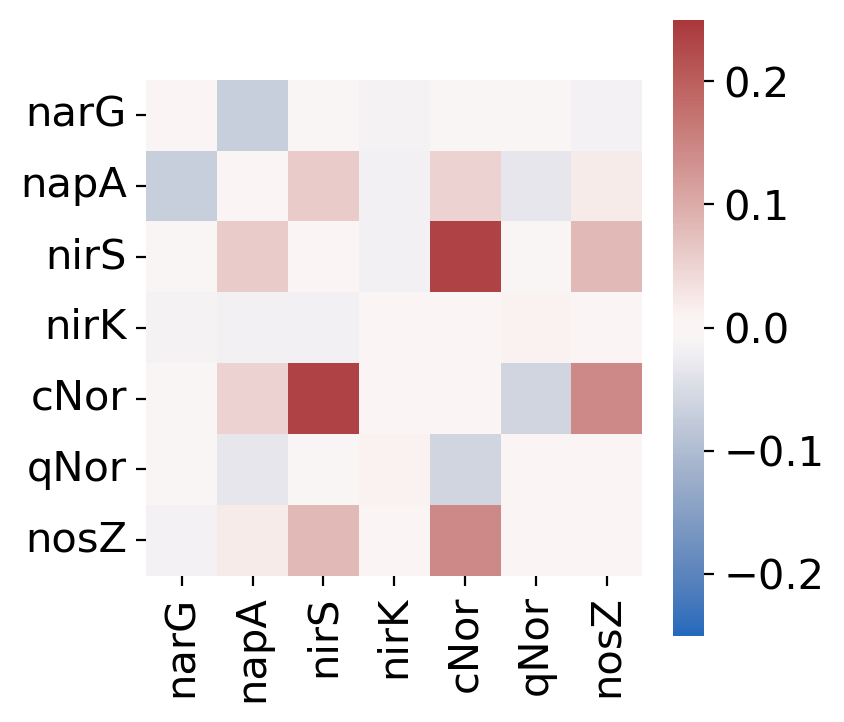

In [18]:
fig=plt.figure(figsize=(4,4))
sns.heatmap(mi, cmap='vlag', vmin=-0.25, vmax=0.25,square=True)